# Setup Environment
Import necessary libraries (pandas, numpy, torch, sklearn), define configuration parameters (paths, hyperparameters, feature engineering settings), and set the computation device (CPU/GPU).

In [139]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.utils.validation import check_is_fitted # <--- ADD THIS
from sklearn.exceptions import NotFittedError # <--- ADD THIS
import xgboost as xgb
import os
import time
import joblib
# --- Configuration ---
# Paths to saved models (Update these paths if needed)
LSTM_MODEL_PATH = "best_lag_lstm_model.pt"
NN_MODEL_PATH = "best_nn_refine_model.pt"
DISTILLED_LSTM_MODEL_PATH = "best_distilled_lstm_separate_model.pt"
TARGET_SCALER_PATH = "LSTM_target_scaler.joblib" # Replace with your target scaler file
LAG_SCALER_PATH = "lag_scaler.pkl" # Replace with your lag scaler file
TEMPORAL_SCALERS_PATH = "LSTM_temporal_scalers.joblib" # ADDED: Path for temporal scalers
# Path to new input data
NEW_DATA_PATH = "traffic.csv" # Replace with your new data file

# Model Hyperparameters (Must match the trained models from your notebook)
# Base LSTM
LSTM_INPUT_DIM = 1
LSTM_HIDDEN_DIM = 256
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.05
LSTM_ATTENTION_DIM = 64
# NN Refinement (Check your notebook for the exact values used)
NN_HIDDEN_DIMS = [128, 128, 64, 64] # Example from notebook
NN_DROPOUT = 0.3 # Example from notebook
# Distilled LSTM (Check your notebook for the exact values used)
DISTILL_HIDDEN_DIM = 320 # Example from notebook
DISTILL_NUM_LAYERS = 3 # Example from notebook
DISTILL_DROPOUT = 0.1 # Example from notebook
DISTILL_ATTENTION_DIM = LSTM_ATTENTION_DIM # Assuming same as base LSTM

# Feature Engineering Params
MAX_LAG = 168
TARGET_COL = 'Vehicles' # Or your target column name
DATETIME_COL = 'DateTime' # Or your datetime column name

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Define Models and Helper Functions
Define the PyTorch model classes (`LagLSTMModel`, `RefinementNN`, `DistillLagLSTMModel`) and helper functions (`create_all_features`, `predict_in_batches`, `predict_distilled_in_batches`) exactly as used during training.

In [140]:
# Function to create features (Copy from notebook or import)
def create_all_features(df, target_col='Vehicles', max_lag=168, datetime_col='DateTime'):
    """Creates lag and temporal features."""
    df_feat = df.copy()
    if datetime_col not in df_feat.columns:
        raise ValueError(f"DateTime column '{datetime_col}' not found in input data.")

    df_feat[datetime_col] = pd.to_datetime(df_feat[datetime_col])
    df_feat = df_feat.sort_values(datetime_col) # Ensure data is sorted by time

    # --- Lag Features ---
    print(f"Creating lag features up to {max_lag} hours...")
    can_create_lags = True
    if target_col not in df_feat.columns:
         print(f"CRITICAL Warning: Target column '{target_col}' not found. Cannot create lag features.")
         can_create_lags = False
         # Add placeholder NaN columns for lags to prevent downstream errors, but fitting will fail
         for lag in range(1, max_lag + 1):
             df_feat[f'lag_{lag}'] = np.nan
    elif len(df_feat) < max_lag + 1:
         print(f"Warning: Input data length ({len(df_feat)}) is less than max_lag+1 ({max_lag+1}). Lag features will contain NaNs at the start.")
         # Proceed, but NaNs will be generated by shift

    if can_create_lags:
        for lag in range(1, max_lag + 1):
            df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
        # Check if any non-NaN lags were actually created
        if df_feat[[f'lag_{lag}' for lag in range(1, max_lag + 1)]].isnull().all().all():
             print("Warning: All created lag features are NaN. This usually means input data was too short or target was missing.")

    # --- Temporal Features ---
    df_feat['hour'] = df_feat[datetime_col].dt.hour
    df_feat['day_of_week'] = df_feat[datetime_col].dt.dayofweek
    df_feat['day'] = df_feat[datetime_col].dt.day
    df_feat['month'] = df_feat[datetime_col].dt.month
    # Cyclical encoding
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour']/24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour']/24)
    df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat['day_of_week']/7)
    df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat['day_of_week']/7)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month']/12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month']/12)
    # Indicators
    df_feat['is_weekend'] = df_feat['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df_feat['is_workday'] = (~df_feat['is_weekend']).astype(int)
    df_feat['morning_rush'] = ((df_feat['hour'] >= 7) & (df_feat['hour'] <= 9)).astype(int)
    df_feat['evening_rush'] = ((df_feat['hour'] >= 16) & (df_feat['hour'] <= 19)).astype(int)
    df_feat['is_rush_hour'] = ((df_feat['morning_rush'] | df_feat['evening_rush']) & df_feat['is_workday']).astype(int)

    # Drop rows with NaNs created by lags (IMPORTANT: This reduces the output size)
    initial_len = len(df_feat)
    # Only drop rows where the largest lag is NaN, *if* lag features were created from target
    lag_col_to_check = f'lag_{max_lag}'
    if can_create_lags and lag_col_to_check in df_feat.columns:
        rows_before_drop = len(df_feat)
        df_feat.dropna(subset=[lag_col_to_check], inplace=True)
        rows_after_drop = len(df_feat)
        print(f"Dropped {rows_before_drop - rows_after_drop} rows due to NaN in '{lag_col_to_check}'.")
        if rows_after_drop == 0:
             print("Warning: All rows dropped after removing NaN lags. Input data likely too short.")
    elif not can_create_lags:
        print("Skipping NaN drop based on lags as lag features could not be created from target.")
    else: # Lags might exist but are all NaN, or column name incorrect
         print(f"Skipping NaN drop based on lags (column '{lag_col_to_check}' not found or lags not created properly).")


    return df_feat

In [141]:
# Define LagLSTMModel (Copy EXACTLY from notebook)
class LagLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, dropout=0.3, attention_dim=64):
        super(LagLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = True # Match notebook
        lstm_output_dim = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0, bidirectional=self.bidirectional
        )
        self.attention_fc1 = nn.Linear(lstm_output_dim, attention_dim)
        self.attention_fc2 = nn.Linear(attention_dim, 1)
        self.layer_norm_lstm = nn.LayerNorm(lstm_output_dim)
        self.layer_norm_context = nn.LayerNorm(lstm_output_dim)
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_norm = self.layer_norm_lstm(lstm_out)
        attn_intermed = torch.tanh(self.attention_fc1(lstm_out_norm))
        attn_scores = self.attention_fc2(attn_intermed)
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out_norm, dim=1)
        context_norm = self.layer_norm_context(context)
        out = self.dropout(context_norm)
        out = self.fc(out)
        return out

In [142]:
# Define RefinementNN (Copy EXACTLY from notebook)
# NOTE: Ensure weight initialization logic is included if it was used during training
import torch.nn.init as init # Make sure init is imported
class RefinementNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_rate=0.4, activation_fn=nn.LeakyReLU(negative_slope=0.01)):
        super(RefinementNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        self.activation_fn = activation_fn
        current_dim = input_dim
        for i, h_dim in enumerate(hidden_dims):
            linear_layer = nn.Linear(current_dim, h_dim)
            self._initialize_weights(linear_layer) # Initialize weights if done in notebook
            self.layers.append(linear_layer)
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            if current_dim != h_dim:
                projection = nn.Linear(current_dim, h_dim)
                self._initialize_weights(projection) # Initialize weights if done in notebook
                self.residual_projections.append(projection)
            else:
                self.residual_projections.append(nn.Identity())
            current_dim = h_dim
        self.output_layer = nn.Linear(current_dim, output_dim)
        self._initialize_weights(self.output_layer) # Initialize weights if done in notebook

    def _initialize_weights(self, layer):
        # Copy the exact initialization from your notebook if you used one
        if isinstance(layer, nn.Linear):
            init.kaiming_uniform_(layer.weight, a=0.01 if isinstance(self.activation_fn, nn.LeakyReLU) else 0, mode='fan_in', nonlinearity='leaky_relu' if isinstance(self.activation_fn, nn.LeakyReLU) else 'relu')
            if layer.bias is not None:
                init.constant_(layer.bias, 0)

    def forward(self, x):
        residual = x
        for i, layer in enumerate(self.layers):
            identity = self.residual_projections[i](residual)
            x = layer(x)
            if x.size(0) > 1: # BatchNorm requires batch size > 1
                 x = self.batch_norms[i](x)
            x = self.activation_fn(x)
            x = x + identity # Add residual connection
            x = self.dropout(x)
            residual = x
        x = self.output_layer(x)
        return x

In [143]:
# Define DistillLagLSTMModel (Copy EXACTLY from notebook)
class DistillLagLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, dropout=0.3, attention_dim=64, temporal_dim=0):
        super(DistillLagLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = True # Match notebook
        lstm_output_dim = hidden_dim * 2 if self.bidirectional else hidden_dim
        self.temporal_dim = temporal_dim
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0, bidirectional=self.bidirectional
        )
        self.attention_fc1 = nn.Linear(lstm_output_dim, attention_dim)
        self.attention_fc2 = nn.Linear(attention_dim, 1)
        self.layer_norm_lstm = nn.LayerNorm(lstm_output_dim)
        self.layer_norm_context = nn.LayerNorm(lstm_output_dim + temporal_dim)
        self.fc = nn.Linear(lstm_output_dim + temporal_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, temporal_features):
        lstm_out, _ = self.lstm(x)
        lstm_out_norm = self.layer_norm_lstm(lstm_out)
        attn_intermed = torch.tanh(self.attention_fc1(lstm_out_norm))
        attn_scores = self.attention_fc2(attn_intermed)
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out_norm, dim=1)
        # Ensure temporal_features has the correct batch dimension
        if temporal_features.dim() == 1:
             temporal_features = temporal_features.unsqueeze(0)
        # Handle potential batch size mismatch (e.g., last batch in dataloader)
        if temporal_features.shape[0] != context.shape[0]:
             if temporal_features.shape[0] == 1 and x.shape[0] > 1:
                 temporal_features = temporal_features.repeat(context.shape[0], 1)
             else:
                 raise ValueError(f"Batch size mismatch: context ({context.shape[0]}) vs temporal_features ({temporal_features.shape[0]})")
        if temporal_features.shape[1] != self.temporal_dim:
             raise ValueError(f"Temporal feature dimension mismatch: expected {self.temporal_dim}, got {temporal_features.shape[1]}")
        combined_context = torch.cat((context, temporal_features), dim=1)
        context_norm = self.layer_norm_context(combined_context)
        out = self.dropout(context_norm)
        out = self.fc(out)
        return out

In [144]:
# Prediction function (can be simplified if batching isn't strictly needed for inference)
def predict_in_batches(model, X_tensor, batch_size=128):
    model.eval()
    device = next(model.parameters()).device
    all_preds_scaled = []
    dataset = TensorDataset(X_tensor)
    # Disable shuffle for prediction
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for (batch_X,) in dataloader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).squeeze()
            if outputs.dim() == 0: # Handle single prediction case
                outputs = outputs.unsqueeze(0)
            all_preds_scaled.append(outputs.cpu().numpy())
    if not all_preds_scaled: return np.array([])
    predictions_scaled = np.concatenate(all_preds_scaled)
    return predictions_scaled.flatten()

def predict_distilled_in_batches(model, X_tensor_lags, temporal_tensor, batch_size=128):
    model.eval()
    device = next(model.parameters()).device
    all_preds_scaled = []
    if len(X_tensor_lags) != len(temporal_tensor):
         raise ValueError("Length mismatch between X_tensor_lags and temporal_tensor")
    dataset = TensorDataset(X_tensor_lags, temporal_tensor)
    # Disable shuffle for prediction
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch_lags, batch_temporal in dataloader:
            batch_lags = batch_lags.to(device)
            batch_temporal = batch_temporal.to(device)
            outputs = model(batch_lags, batch_temporal).squeeze()
            if outputs.dim() == 0: outputs = outputs.unsqueeze(0)
            all_preds_scaled.append(outputs.cpu().numpy())
    if not all_preds_scaled: return np.array([])
    predictions_scaled = np.concatenate(all_preds_scaled)
    return predictions_scaled.flatten()

# Load and Prepare Data
Load the new input data CSV. Apply the `create_all_features` function to generate lag and temporal features. Handle potential errors if data is insufficient or columns are missing.

In [145]:
# --- 1. Load Scalers (Placeholder) ---
print("--- Initializing and attempting to load scalers ---")

# Initialize scalers with unfitted placeholders and flags to False
target_scaler = QuantileTransformer(output_distribution='normal')
target_scaler_is_loaded = False
lag_scaler = StandardScaler()
lag_scaler_is_loaded = False
temporal_scaler = StandardScaler() # Assuming temporal scaler is StandardScaler
temporal_scaler_is_loaded = False

# Attempt to load the target_scaler
try:
    if 'TARGET_SCALER_PATH' in locals() and TARGET_SCALER_PATH:
        if os.path.exists(TARGET_SCALER_PATH):
            loaded_object = joblib.load(TARGET_SCALER_PATH)
            if isinstance(loaded_object, QuantileTransformer):
                try:
                    check_is_fitted(loaded_object) # <--- MODIFIED CHECK
                    target_scaler = loaded_object
                    target_scaler_is_loaded = True
                    print(f"Successfully loaded AND VERIFIED FITTED target_scaler from {TARGET_SCALER_PATH}")
                except NotFittedError: # <--- MODIFIED EXCEPTION
                    print(f"Loaded target_scaler from {TARGET_SCALER_PATH} but it's NOT FITTED. Will attempt to re-fit.")
                    # target_scaler remains the unfitted placeholder, target_scaler_is_loaded remains False
            else:
                print(f"Object loaded from {TARGET_SCALER_PATH} is not a QuantileTransformer. Will attempt to fit a new one.")
        else:
            print(f"Target scaler file not found at {TARGET_SCALER_PATH}. Will attempt to fit.")
    else:
        print("TARGET_SCALER_PATH is not defined or is empty. Will attempt to fit target_scaler.")
except Exception as e:
    print(f"Error processing target_scaler from {TARGET_SCALER_PATH}: {e}. Will attempt to fit.")
    # target_scaler remains placeholder, target_scaler_is_loaded remains False

# Attempt to load the lag_scaler
try:
    if 'LAG_SCALER_PATH' in locals() and LAG_SCALER_PATH:
        if os.path.exists(LAG_SCALER_PATH):
            loaded_object = joblib.load(LAG_SCALER_PATH)
            if isinstance(loaded_object, StandardScaler):
                try:
                    check_is_fitted(loaded_object) # <--- MODIFIED CHECK
                    lag_scaler = loaded_object
                    lag_scaler_is_loaded = True
                    print(f"Successfully loaded AND VERIFIED FITTED lag_scaler from {LAG_SCALER_PATH}")
                except NotFittedError: # <--- MODIFIED EXCEPTION
                    print(f"Loaded lag_scaler from {LAG_SCALER_PATH} but it's NOT FITTED. Will attempt to re-fit.")
            else:
                print(f"Object loaded from {LAG_SCALER_PATH} is not a StandardScaler. Will attempt to fit a new one.")
        else:
            print(f"Lag scaler file not found at {LAG_SCALER_PATH}. Will attempt to fit.")
    else:
        print("LAG_SCALER_PATH is not defined or is empty. Will attempt to fit lag_scaler.")
except Exception as e:
    print(f"Error processing lag_scaler from {LAG_SCALER_PATH}: {e}. Will attempt to fit.")

# Attempt to load the temporal_scaler
try:
    if 'TEMPORAL_SCALERS_PATH' in locals() and TEMPORAL_SCALERS_PATH:
        if os.path.exists(TEMPORAL_SCALERS_PATH):
            loaded_object = joblib.load(TEMPORAL_SCALERS_PATH)
            if isinstance(loaded_object, StandardScaler): # Assuming temporal is StandardScaler
                try:
                    check_is_fitted(loaded_object) # <--- MODIFIED CHECK
                    temporal_scaler = loaded_object
                    temporal_scaler_is_loaded = True
                    print(f"Successfully loaded AND VERIFIED FITTED temporal_scaler from {TEMPORAL_SCALERS_PATH}")
                except NotFittedError: # <--- MODIFIED EXCEPTION
                    print(f"Loaded temporal_scaler from {TEMPORAL_SCALERS_PATH} but it's NOT FITTED. Will attempt to re-fit.")
            else:
                print(f"Object loaded from {TEMPORAL_SCALERS_PATH} is not a StandardScaler. Will attempt to fit a new one.")
        else:
            print(f"Temporal scalers file not found at {TEMPORAL_SCALERS_PATH}. Will attempt to fit.")
    else:
        print("TEMPORAL_SCALERS_PATH is not defined or is empty. Will attempt to fit temporal_scaler.")
except Exception as e:
    print(f"Error processing temporal_scaler from {TEMPORAL_SCALERS_PATH}: {e}. Will attempt to fit.")


# This global flag indicates if all necessary scalers are ready (loaded or fitted).
scalers_fitted = False # Will be updated by the 'Fit Scalers' cell

if not target_scaler_is_loaded:
    print("--- NOTE: target_scaler was not loaded/verified. It will be fitted in the 'Fit Scalers' cell if data is sufficient. ---")
else:
    print("--- NOTE: target_scaler loaded and verified. It will NOT be re-fitted. ---")

if not lag_scaler_is_loaded:
    print("--- NOTE: lag_scaler was not loaded/verified. It will be fitted in the 'Fit Scalers' cell if data is sufficient. ---")
else:
    print("--- NOTE: lag_scaler loaded and verified. It will NOT be re-fitted. ---")

if not temporal_scaler_is_loaded:
    print("--- NOTE: temporal_scaler was not loaded/verified. It will be fitted in the 'Fit Scalers' cell if data is sufficient. ---")
else:
    print("--- NOTE: temporal_scaler loaded and verified. It will NOT be re-fitted. ---")

--- Initializing and attempting to load scalers ---
Successfully loaded AND VERIFIED FITTED target_scaler from LSTM_target_scaler.joblib
Successfully loaded AND VERIFIED FITTED lag_scaler from lag_scaler.pkl
Successfully loaded AND VERIFIED FITTED temporal_scaler from LSTM_temporal_scalers.joblib
--- NOTE: target_scaler loaded and verified. It will NOT be re-fitted. ---
--- NOTE: lag_scaler loaded and verified. It will NOT be re-fitted. ---
--- NOTE: temporal_scaler loaded and verified. It will NOT be re-fitted. ---


In [146]:
# --- 2. Load Data and Define Test Set (Last 20% of Junction 1) ---
print(f"Loading data from {NEW_DATA_PATH}...")
try:
    full_df = pd.read_csv(NEW_DATA_PATH)
    if DATETIME_COL not in full_df.columns:
         raise ValueError(f"Required column '{DATETIME_COL}' not in {NEW_DATA_PATH}")
    if 'Junction' not in full_df.columns:
         raise ValueError(f"Required column 'Junction' not in {NEW_DATA_PATH}")
    if TARGET_COL not in full_df.columns:
         raise ValueError(f"Required column '{TARGET_COL}' not in {NEW_DATA_PATH}")

    print("Filtering for Junction 1 and sorting by DateTime...")
    junction_df = full_df[full_df['Junction'] == 1].copy()
    junction_df[DATETIME_COL] = pd.to_datetime(junction_df[DATETIME_COL])
    junction_df = junction_df.sort_values(DATETIME_COL).reset_index(drop=True)

    if len(junction_df) < MAX_LAG + 24: # Minimum for any reasonable test
        raise ValueError(f"Insufficient data for Junction 1. Need at least {MAX_LAG + 24} rows, found {len(junction_df)}.")

    # Determine the test set (last 20% of Junction 1)
    test_set_percentage = 0.20
    num_test_rows = int(len(junction_df) * test_set_percentage)
    
    if num_test_rows < 24: # Ensure test set is at least 24 hours if possible
        print(f"Warning: 20% of data ({num_test_rows} rows) is less than 24 hours. Adjusting test set size if total data allows.")
        num_test_rows = min(24, len(junction_df) - MAX_LAG) # Ensure we can at least form lags for a 24h test
        if num_test_rows < 1:
             raise ValueError(f"Test set size is less than 1 ({num_test_rows}) after attempting to ensure 24h and lag requirements. Insufficient data.")


    # The actual prediction horizon for the "whole test set"
    prediction_horizon_test_set = num_test_rows 
    
    # Data needed for feature engineering: MAX_LAG rows before the start of the test set
    # The `new_df` will contain these MAX_LAG rows + the actual test_set rows
    test_set_start_index = len(junction_df) - prediction_horizon_test_set
    data_for_test_start_index = test_set_start_index - MAX_LAG

    if data_for_test_start_index < 0:
        print(f"Warning: Not enough historical data to create full lags for the start of the 20% test set.")
        print(f"Required start index for lags: {data_for_test_start_index}. Available data starts at index 0.")
        print(f"The effective test set will be shorter or feature engineering might produce more NaNs at the beginning.")
        # Adjust `new_df` to take all available data if full history for lags isn't present
        # This means create_all_features will handle NaNs, and the resulting data_feat might be shorter than prediction_horizon_test_set
        new_df = junction_df.copy()
        # The actual number of predictable points will be len(junction_df) - MAX_LAG
        prediction_horizon_test_set = max(0, len(junction_df) - MAX_LAG)
        print(f"Adjusted prediction_horizon_test_set to {prediction_horizon_test_set} based on available data and MAX_LAG.")

    else:
        new_df = junction_df.iloc[data_for_test_start_index:].copy()

    if new_df.empty:
        raise ValueError("`new_df` is empty after selecting data for the test set. Check data slicing logic.")
    
    # This `prediction_horizon` is now the length of our 20% test set.
    # It will be used by subsequent cells implicitly through the length of `data_feat`
    # We will use a separate variable (e.g., `eval_24h_horizon`) for the 24-hour specific evaluation.
    print(f"Selected {len(new_df)} rows for Junction 1 to predict the final {prediction_horizon_test_set} data points (last 20% or adjusted).")
    print(f"The 'prediction_horizon' for the full test set evaluation will be {prediction_horizon_test_set} points.")

except FileNotFoundError:
    print(f"Error: Input data file not found at {NEW_DATA_PATH}")
    raise
except Exception as e:
    print(f"Error loading or preparing data for test set: {e}")
    raise

Loading data from traffic.csv...
Filtering for Junction 1 and sorting by DateTime...
Selected 3086 rows for Junction 1 to predict the final 2918 data points (last 20% or adjusted).
The 'prediction_horizon' for the full test set evaluation will be 2918 points.


In [147]:
# --- 3. Feature Engineering ---
print("Performing feature engineering...")
# Note: If predicting future steps where target is unknown, you MUST prepend
# sufficient historical data (including the target) to new_df BEFORE this step
# to allow lag calculation.
try:
    # If target column is missing for future prediction, create_all_features needs modification
    # or historical data must be prepended. Assuming target exists or historical data is present.
    data_feat = create_all_features(new_df, target_col=TARGET_COL, max_lag=MAX_LAG, datetime_col=DATETIME_COL)
    if data_feat.empty:
        print("Error: No data remaining after feature engineering (likely due to insufficient history for lags).")
        # exit()
        raise ValueError("Feature engineering resulted in empty DataFrame.")
    print(f"Data shape after feature engineering: {data_feat.shape}")
except Exception as e:
    print(f"Error during feature engineering: {e}")
    # exit()
    raise

Performing feature engineering...
Creating lag features up to 168 hours...
Dropped 168 rows due to NaN in 'lag_168'.
Data shape after feature engineering: (2918, 187)


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [148]:
# --- 4. Fit Scalers (Using Training Portion of Junction 1 Data) ---
print("\n--- Attempting to fit scalers using the training portion (first 80%) of Junction 1 data ---")

lag_features_fit = [f'lag_{i}' for i in range(1, MAX_LAG + 1)]
temporal_features_fit = [
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'is_weekend', 'day',
    'morning_rush', 'evening_rush', 'is_rush_hour', 'is_workday'
]

# lag_scaler = StandardScaler()
# temporal_scaler = StandardScaler()
# target_scaler = QuantileTransformer(output_distribution='normal') # Or match your training
# scalers_fitted = False

if 'junction_df' in locals() and isinstance(junction_df, pd.DataFrame) and not junction_df.empty:
    # Determine the training set (first 80% of Junction 1)
    # prediction_horizon_test_set was defined in the previous cell (length of the 20% test data)
    if 'prediction_horizon_test_set' not in locals() or prediction_horizon_test_set < 0:
         raise ValueError("'prediction_horizon_test_set' is not defined or invalid from the previous cell.")

    training_data_end_index = len(junction_df) - prediction_horizon_test_set
    
    if training_data_end_index < MAX_LAG + 1: # Need at least MAX_LAG+1 rows to get any data after feature eng.
        print(f"Warning: Training data slice for Junction 1 ({training_data_end_index} rows) is too short to create features for scaler fitting. Needs at least {MAX_LAG + 1} rows.")
        scalers_fitted = False
    else:
        scaler_fitting_df_train = junction_df.iloc[:training_data_end_index].copy()
        print(f"Using {len(scaler_fitting_df_train)} rows from Junction 1 (first ~80%) for scaler fitting.")

        if len(scaler_fitting_df_train) >= MAX_LAG + 1:
            print("Applying feature engineering to scaler fitting data (Junction 1 training portion)...")
            try:
                if TARGET_COL not in scaler_fitting_df_train.columns:
                     raise ValueError(f"Target column '{TARGET_COL}' missing in scaler fitting data slice for Junction 1 training.")

                train_df_feat_for_scaling = create_all_features(
                    scaler_fitting_df_train,
                    target_col=TARGET_COL,
                    max_lag=MAX_LAG,
                    datetime_col=DATETIME_COL
                )

                if train_df_feat_for_scaling.empty:
                    print("CRITICAL: Feature engineering on training data for fitting resulted in empty DataFrame. Cannot fit scalers.")
                    scalers_fitted = False
                else:
                     print(f"Training data for fitting shape after feature engineering: {train_df_feat_for_scaling.shape}")
                     # Check for missing columns and NaNs before fitting (similar to your existing detailed checks)
                     missing_lag_fit = [col for col in lag_features_fit if col not in train_df_feat_for_scaling.columns]
                     missing_temp_fit = [col for col in temporal_features_fit if col not in train_df_feat_for_scaling.columns]
                     missing_target_fit = TARGET_COL not in train_df_feat_for_scaling.columns

                     if missing_lag_fit or missing_temp_fit or missing_target_fit:
                         print("CRITICAL: Missing required columns in train_df_feat_for_scaling. Cannot fit scalers.")
                         # (add more detailed printouts of missing columns if desired)
                         scalers_fitted = False
                     elif train_df_feat_for_scaling[lag_features_fit].isnull().values.any() or \
                          train_df_feat_for_scaling[temporal_features_fit].isnull().values.any() or \
                          train_df_feat_for_scaling[[TARGET_COL]].isnull().values.any():
                         print("CRITICAL: NaN values found in columns needed for fitting in train_df_feat_for_scaling. Cannot fit scalers.")
                         # (add more detailed printouts of NaNs if desired)
                         scalers_fitted = False
                     else:
                         # Inside cell id="2d33014f"
                        # After train_df_feat_for_scaling is prepared and checks are passed:
                        print("All pre-fitting checks passed for training data. Fitting scalers...")
                        try:
                            lag_scaler.fit(train_df_feat_for_scaling[lag_features_fit])
                            print(" - Lag scaler fitted on Junction 1 training data.")
                            temporal_scaler.fit(train_df_feat_for_scaling[temporal_features_fit])
                            print(" - Temporal scaler fitted on Junction 1 training data.")

                            if not target_scaler_is_loaded: # Check the flag from the loading cell
                                target_scaler.fit(train_df_feat_for_scaling[[TARGET_COL]])
                                print(" - Target scaler fitted on Junction 1 training data.")
                            else:
                                print(" - Target scaler was pre-loaded, skipping fitting.")
                            
                        except Exception as e:
                             print(f"An error occurred during scaler fitting on training data: {e}")
                             scalers_fitted = False
            except Exception as e:
                print(f"Error during feature engineering for scaler fitting data (Junction 1 training): {e}")
                scalers_fitted = False
        else:
             print(f"Warning: The training data slice for fitting ({len(scaler_fitting_df_train)} rows) is too short. Needs at least {MAX_LAG + 1} rows for feature engineering.")
             scalers_fitted = False
else:
    print("Warning: 'junction_df' (for Junction 1) not available or empty. Cannot fit scalers.")
    scalers_fitted = False

print(f"\nScaler fitting process complete. `scalers_fitted` = {scalers_fitted}")


--- Attempting to fit scalers using the training portion (first 80%) of Junction 1 data ---
Using 11674 rows from Junction 1 (first ~80%) for scaler fitting.
Applying feature engineering to scaler fitting data (Junction 1 training portion)...
Creating lag features up to 168 hours...
Dropped 168 rows due to NaN in 'lag_168'.
Training data for fitting shape after feature engineering: (11506, 187)
All pre-fitting checks passed for training data. Fitting scalers...
 - Lag scaler fitted on Junction 1 training data.
 - Temporal scaler fitted on Junction 1 training data.
 - Target scaler was pre-loaded, skipping fitting.

Scaler fitting process complete. `scalers_fitted` = False


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

# Scale Features
Load the pre-fitted scalers (e.g., StandardScaler, QuantileTransformer) for lag, temporal, and target features. Apply `transform` to the engineered features. Include warnings if scalers are not available and placeholder/unscaled data is used.

In [149]:
# --- 4. Fit Scalers (Using Training Portion of Junction 1 Data) ---
print("\n--- Attempting to fit scalers using the training portion (first 80%) of Junction 1 data ---")

lag_features_fit = [f'lag_{i}' for i in range(1, MAX_LAG + 1)]
temporal_features_fit = [
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'is_weekend', 'day',
    'morning_rush', 'evening_rush', 'is_rush_hour', 'is_workday'
]

# Scalers are already initialized (or loaded) in the previous cell.
# We will only fit them if they were not loaded.
scalers_fitted = False # Reset and update based on this cell's outcome

# Local flags to track if fitting was successful in this cell
lag_scaler_fitted_this_cell = False
temporal_scaler_fitted_this_cell = False
target_scaler_fitted_this_cell = False


if 'junction_df' in locals() and isinstance(junction_df, pd.DataFrame) and not junction_df.empty:
    if 'prediction_horizon_test_set' not in locals() or prediction_horizon_test_set < 0:
         raise ValueError("'prediction_horizon_test_set' is not defined or invalid from the previous cell.")

    training_data_end_index = len(junction_df) - prediction_horizon_test_set
    
    if training_data_end_index < MAX_LAG + 1:
        print(f"Warning: Training data slice for Junction 1 ({training_data_end_index} rows) is too short to create features for scaler fitting. Needs at least {MAX_LAG + 1} rows.")
        # scalers_fitted remains False
    else:
        scaler_fitting_df_train = junction_df.iloc[:training_data_end_index].copy()
        print(f"Using {len(scaler_fitting_df_train)} rows from Junction 1 (first ~80%) for scaler fitting.")

        if len(scaler_fitting_df_train) >= MAX_LAG + 1:
            print("Applying feature engineering to scaler fitting data (Junction 1 training portion)...")
            try:
                if TARGET_COL not in scaler_fitting_df_train.columns:
                     raise ValueError(f"Target column '{TARGET_COL}' missing in scaler fitting data slice for Junction 1 training.")

                train_df_feat_for_scaling = create_all_features(
                    scaler_fitting_df_train,
                    target_col=TARGET_COL,
                    max_lag=MAX_LAG,
                    datetime_col=DATETIME_COL
                )

                if train_df_feat_for_scaling.empty:
                    print("CRITICAL: Feature engineering on training data for fitting resulted in empty DataFrame. Cannot fit scalers.")
                    # scalers_fitted remains False
                else:
                     print(f"Training data for fitting shape after feature engineering: {train_df_feat_for_scaling.shape}")
                     missing_lag_fit = [col for col in lag_features_fit if col not in train_df_feat_for_scaling.columns]
                     missing_temp_fit = [col for col in temporal_features_fit if col not in train_df_feat_for_scaling.columns]
                     missing_target_fit = TARGET_COL not in train_df_feat_for_scaling.columns

                     if missing_lag_fit or missing_temp_fit or missing_target_fit:
                         print("CRITICAL: Missing required columns in train_df_feat_for_scaling. Cannot fit scalers.")
                         if missing_lag_fit: print(f"Missing lag features for fitting: {missing_lag_fit}")
                         if missing_temp_fit: print(f"Missing temporal features for fitting: {missing_temp_fit}")
                         if missing_target_fit: print(f"Missing target column for fitting: {TARGET_COL}")
                         # scalers_fitted remains False
                     elif train_df_feat_for_scaling[lag_features_fit].isnull().values.any() or \
                          train_df_feat_for_scaling[temporal_features_fit].isnull().values.any() or \
                          train_df_feat_for_scaling[[TARGET_COL]].isnull().values.any():
                         print("CRITICAL: NaN values found in columns needed for fitting in train_df_feat_for_scaling. Cannot fit scalers.")
                         # (add more detailed printouts of NaNs if desired)
                         # scalers_fitted remains False
                     else:
                        print("All pre-fitting checks passed for training data. Conditionally fitting scalers...")
                        try:
                            if not lag_scaler_is_loaded:
                                print("Attempting to fit lag_scaler...")
                                lag_scaler.fit(train_df_feat_for_scaling[lag_features_fit])
                                print(" - Lag scaler fitted on Junction 1 training data.")
                                lag_scaler_fitted_this_cell = True
                            else:
                                print(" - Lag scaler was pre-loaded, skipping fitting.")
                                lag_scaler_fitted_this_cell = True # Considered "ready"

                            if not temporal_scaler_is_loaded:
                                print("Attempting to fit temporal_scaler...")
                                temporal_scaler.fit(train_df_feat_for_scaling[temporal_features_fit])
                                print(" - Temporal scaler fitted on Junction 1 training data.")
                                temporal_scaler_fitted_this_cell = True
                            else:
                                print(" - Temporal scaler was pre-loaded, skipping fitting.")
                                temporal_scaler_fitted_this_cell = True # Considered "ready"

                            if not target_scaler_is_loaded:
                                print("Attempting to fit target_scaler...")
                                target_scaler.fit(train_df_feat_for_scaling[[TARGET_COL]])
                                print(" - Target scaler fitted on Junction 1 training data.")
                                target_scaler_fitted_this_cell = True
                            else:
                                print(" - Target scaler was pre-loaded, skipping fitting.")
                                target_scaler_fitted_this_cell = True # Considered "ready"
                            
                            # Update global scalers_fitted flag
                            if lag_scaler_fitted_this_cell and temporal_scaler_fitted_this_cell and target_scaler_fitted_this_cell:
                                scalers_fitted = True
                                print(">>> All necessary scalers are now ready (loaded or fitted).")
                            else:
                                print(">>> Not all scalers could be prepared (loaded or fitted).")
                                scalers_fitted = False

                        except Exception as e:
                             print(f"An error occurred during scaler fitting on training data: {e}")
                             scalers_fitted = False # Fitting failed
            except Exception as e:
                print(f"Error during feature engineering for scaler fitting data (Junction 1 training): {e}")
                scalers_fitted = False # Feature engineering failed
        else:
             print(f"Warning: The training data slice for fitting ({len(scaler_fitting_df_train)} rows) is too short. Needs at least {MAX_LAG + 1} rows for feature engineering.")
             scalers_fitted = False
else:
    print("Warning: 'junction_df' (for Junction 1) not available or empty. Cannot fit scalers.")
    scalers_fitted = False

print(f"\nScaler preparation process complete. `scalers_fitted` = {scalers_fitted}")


--- Attempting to fit scalers using the training portion (first 80%) of Junction 1 data ---
Using 11674 rows from Junction 1 (first ~80%) for scaler fitting.
Applying feature engineering to scaler fitting data (Junction 1 training portion)...
Creating lag features up to 168 hours...
Dropped 168 rows due to NaN in 'lag_168'.
Training data for fitting shape after feature engineering: (11506, 187)
All pre-fitting checks passed for training data. Conditionally fitting scalers...
 - Lag scaler was pre-loaded, skipping fitting.
 - Temporal scaler was pre-loaded, skipping fitting.
 - Target scaler was pre-loaded, skipping fitting.
>>> All necessary scalers are now ready (loaded or fitted).

Scaler preparation process complete. `scalers_fitted` = True


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1163979556.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [150]:
# --- 4. Scaling ---
print("Applying scaling...")

# Define the feature lists needed for scaling (must match training/fitting)
# !!! Verify these lists match your original training setup !!!
lag_features = [f'lag_{i}' for i in range(1, MAX_LAG + 1)]
temporal_features = [
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'is_weekend', 'day',
    'morning_rush', 'evening_rush', 'is_rush_hour', 'is_workday'
]
# Define interaction features names if needed by NN refinement (copy from notebook)
# Example: Ensure these names match those used when training the NN Refinement model
interaction_features_names = [
    'lstm_x_hour_sin', 'lstm_x_hour_cos', 'lstm_x_is_weekend', 'lstm_x_is_rush'
]
# Define features for NN refinement input (copy from notebook)
# Example: Ensure the order and names match the input expected by the NN Refinement model
nn_refinement_features = ['lstm_pred'] + temporal_features + interaction_features_names

# Define original_datetimes (should come from data_feat before scaling)
# Ensure data_feat exists from cell 3712c034
if 'data_feat' in locals() and isinstance(data_feat, pd.DataFrame) and DATETIME_COL in data_feat.columns:
    original_datetimes = data_feat[DATETIME_COL].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Captured {len(original_datetimes)} original datetimes for results alignment.")
else:
    print("CRITICAL Warning: Could not capture original_datetimes from data_feat. Results alignment will likely fail.")
    original_datetimes = pd.Series([], dtype='datetime64[ns]') # Placeholder to avoid NameError, but indicates a problem


# Check if scalers are fitted before attempting to transform
if not scalers_fitted:
    # Raise an error to stop execution - prevents using unscaled data incorrectly
    raise RuntimeError(
        "Scalers were not successfully fitted in the previous step (cell '2f82ac9e'). "
        "Cannot proceed with scaling. Check the output of the 'Fit Scalers' cell "
        "to diagnose why fitting failed (e.g., insufficient data, NaNs, missing columns)."
    )
else:
    # Scalers are fitted, proceed with transform
    print("Applying FITTED scalers...")
    try:
        # Check if columns exist in data_feat before scaling
        missing_lags_scale = [col for col in lag_features if col not in data_feat.columns]
        missing_temps_scale = [col for col in temporal_features if col not in data_feat.columns]
        if missing_lags_scale:
            raise ValueError(f"Missing required lag columns in data_feat for scaling: {missing_lags_scale}")
        if missing_temps_scale:
            raise ValueError(f"Missing required temporal columns in data_feat for scaling: {missing_temps_scale}")

        # Check for NaNs in the specific columns before scaling
        if data_feat[lag_features].isnull().values.any():
             print(f"Warning: NaNs found in lag features ({data_feat[lag_features].isnull().sum().sum()} total) before applying lag_scaler.transform. This might cause issues or errors.")
             # Consider adding imputation here if needed, e.g.:
             # data_feat.loc[:, lag_features] = data_feat[lag_features].fillna(data_feat[lag_features].mean()) # Or median(), 0, etc.
        if data_feat[temporal_features].isnull().values.any():
             print(f"Warning: NaNs found in temporal features ({data_feat[temporal_features].isnull().sum().sum()} total) before applying temporal_scaler.transform. This might cause issues or errors.")
             # Consider adding imputation here if needed

        X_lags_scaled = lag_scaler.transform(data_feat[lag_features])
        X_temporal_scaled = temporal_scaler.transform(data_feat[temporal_features])
        print("-> Applied fitted lag and temporal scalers.")

    except Exception as e:
        print(f"Error applying scaling even though scalers were marked as fitted: {e}")
        # Re-raise the error to halt execution, as scaling failed unexpectedly
        raise

# Add a check for the output shapes
print(f"Shape of X_lags_scaled: {X_lags_scaled.shape if 'X_lags_scaled' in locals() else 'Not generated'}")
print(f"Shape of X_temporal_scaled: {X_temporal_scaled.shape if 'X_temporal_scaled' in locals() else 'Not generated'}")

Applying scaling...
Captured 2918 original datetimes for results alignment.
Applying FITTED scalers...
-> Applied fitted lag and temporal scalers.
Shape of X_lags_scaled: (2918, 168)
Shape of X_temporal_scaled: (2918, 12)


# Create Data Tensors
Reshape the scaled features as required by the models (e.g., lags into sequences for LSTM) and convert the NumPy arrays into PyTorch tensors, moving them to the configured device.

In [151]:
# --- 5. Prepare Data for Models ---
print("Preparing data for models...")
# LSTM Input
seq_length = MAX_LAG
num_features = 1 # As per notebook (each lag step is one feature)
# Reshape lags: (num_samples, seq_length, num_features)
# Ensure the last dimension is 1
X_lstm_input = X_lags_scaled.reshape(-1, seq_length, num_features)
X_lstm_tensor = torch.tensor(X_lstm_input, dtype=torch.float32).to(device)
print(f"LSTM input tensor shape: {X_lstm_tensor.shape}")

# Temporal Features Tensor (for Distilled LSTM and Refinement)
X_temporal_tensor = torch.tensor(X_temporal_scaled, dtype=torch.float32).to(device)
print(f"Temporal features tensor shape: {X_temporal_tensor.shape}")

Preparing data for models...
LSTM input tensor shape: torch.Size([2918, 168, 1])
Temporal features tensor shape: torch.Size([2918, 12])


# Load Trained Models
Instantiate the model classes (`LagLSTMModel`, `RefinementNN`, `DistillLagLSTMModel`) with the correct hyperparameters. Load the saved state dictionaries (`.pt` files) into the models. Set models to evaluation mode (`.eval()`).

In [152]:
# --- 6. Load Models ---
print("Loading trained models...")
# Base LSTM
try:
    lstm_model = LagLSTMModel(
        input_dim=LSTM_INPUT_DIM, hidden_dim=LSTM_HIDDEN_DIM, num_layers=LSTM_NUM_LAYERS,
        dropout=LSTM_DROPOUT, attention_dim=LSTM_ATTENTION_DIM
    ).to(device)
    lstm_model.load_state_dict(torch.load(LSTM_MODEL_PATH, map_location=device))
    lstm_model.eval()
    print(f" - Base LSTM model loaded from {LSTM_MODEL_PATH}")
except Exception as e:
    print(f"Error loading Base LSTM model: {e}")
    # exit()
    raise

Loading trained models...
 - Base LSTM model loaded from best_lag_lstm_model.pt


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\2542573428.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(LSTM_MODEL_PATH, map_loc

In [153]:
# NN Refinement
# Determine NN input dimension dynamically based on features used in notebook
# Input: LSTM prediction (1) + scaled temporal features + interaction features
nn_input_dim = 1 + len(temporal_features) + len(interaction_features_names)
print(f"Calculated NN Refinement input dimension: {nn_input_dim}")
try:
    nn_refine_model = RefinementNN(
        input_dim=nn_input_dim, # Calculated dimension
        hidden_dims=NN_HIDDEN_DIMS,
        dropout_rate=NN_DROPOUT,
        # Ensure activation function matches notebook
        activation_fn=nn.LeakyReLU(negative_slope=0.01)
    ).to(device)
    nn_refine_model.load_state_dict(torch.load(NN_MODEL_PATH, map_location=device))
    nn_refine_model.eval()
    print(f" - NN Refinement model loaded from {NN_MODEL_PATH}")
except Exception as e:
    print(f"Error loading NN Refinement model: {e}")
    # exit()
    raise

Calculated NN Refinement input dimension: 17
 - NN Refinement model loaded from best_nn_refine_model.pt


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\1209105076.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_refine_model.load_state_dict(torch.load(NN_MODEL_PATH, map

In [154]:
# Distilled LSTM
num_temporal_features = len(temporal_features)
print(f"Number of temporal features for Distilled LSTM: {num_temporal_features}")
try:
    distilled_lstm_model = DistillLagLSTMModel(
        input_dim=LSTM_INPUT_DIM, # Input is still 1 feature per step in sequence
        hidden_dim=DISTILL_HIDDEN_DIM,
        output_dim=1,
        num_layers=DISTILL_NUM_LAYERS,
        dropout=DISTILL_DROPOUT,
        attention_dim=DISTILL_ATTENTION_DIM,
        temporal_dim=num_temporal_features # Pass the number of temporal features
    ).to(device)
    distilled_lstm_model.load_state_dict(torch.load(DISTILLED_LSTM_MODEL_PATH, map_location=device))
    distilled_lstm_model.eval()
    print(f" - Distilled LSTM model loaded from {DISTILLED_LSTM_MODEL_PATH}")
except Exception as e:
    print(f"Error loading Distilled LSTM model: {e}")
    # exit()
    raise

Number of temporal features for Distilled LSTM: 12
 - Distilled LSTM model loaded from best_distilled_lstm_separate_model.pt


C:\Users\PLN\AppData\Local\Temp\ipykernel_13824\2251895414.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distilled_lstm_model.load_state_dict(torch.load(DISTILLED_LST

# Generate Base LSTM Predictions
Use the `predict_in_batches` function with the loaded base LSTM model and the prepared lag feature tensor to generate scaled predictions.

In [155]:
# --- 7. Run Predictions ---
print("\nRunning predictions...")

# 7.1 Base LSTM Prediction
print(" - Generating Base LSTM predictions...")
lstm_pred_scaled = predict_in_batches(lstm_model, X_lstm_tensor)
print(f"   Generated {len(lstm_pred_scaled)} base LSTM predictions (scaled).")


Running predictions...
 - Generating Base LSTM predictions...
   Generated 2918 base LSTM predictions (scaled).


# Generate NN Refinement Predictions
Prepare the input tensor for the refinement NN, including the scaled predictions from the base LSTM, scaled temporal features, and interaction features. Use the `predict_in_batches` function with the loaded NN model.

In [156]:
# 7.2 NN Refinement Prediction
print(" - Generating NN Refinement predictions...")
# Prepare input: LSTM prediction + Temporal Features + Interaction Features
# Create interaction features using the *scaled* LSTM predictions and *scaled* temporal features

# Use the scaled temporal features numpy array directly
refine_input_df_temp = pd.DataFrame(X_temporal_scaled, columns=temporal_features)
refine_input_df_temp['lstm_pred'] = lstm_pred_scaled # Add scaled LSTM prediction

# Calculate interaction features (ensure column names match NN input)
# Use .get() with default 0 in case a feature is missing (though checked earlier)
refine_input_df_temp['lstm_x_hour_sin'] = refine_input_df_temp['lstm_pred'] * refine_input_df_temp.get('hour_sin', 0)
refine_input_df_temp['lstm_x_hour_cos'] = refine_input_df_temp['lstm_pred'] * refine_input_df_temp.get('hour_cos', 0)
refine_input_df_temp['lstm_x_is_weekend'] = refine_input_df_temp['lstm_pred'] * refine_input_df_temp.get('is_weekend', 0)
refine_input_df_temp['lstm_x_is_rush'] = refine_input_df_temp['lstm_pred'] * refine_input_df_temp.get('is_rush_hour', 0)

# Select columns in the correct order expected by the NN model
try:
    # Ensure the order matches nn_refinement_features definition
    X_nn_refine_input = refine_input_df_temp[nn_refinement_features].values
    print(f"   NN Refinement input shape: {X_nn_refine_input.shape}")
except KeyError as e:
    print(f"Error: Missing column for NN input: {e}. Check feature names: {nn_refinement_features}")
    # exit()
    raise

X_nn_refine_tensor = torch.tensor(X_nn_refine_input, dtype=torch.float32).to(device)

 - Generating NN Refinement predictions...
   NN Refinement input shape: (2918, 17)


In [157]:
# Run prediction for NN Refinement
nn_pred_scaled = predict_in_batches(nn_refine_model, X_nn_refine_tensor)
print(f"   Generated {len(nn_pred_scaled)} NN Refinement predictions (scaled).")

   Generated 2918 NN Refinement predictions (scaled).


# Generate Distilled LSTM Predictions
Use the `predict_distilled_in_batches` function with the loaded distilled LSTM model, providing both the lag feature tensor and the temporal feature tensor as input.

In [158]:
# 7.3 Distilled LSTM Prediction
print(" - Generating Distilled LSTM predictions...")
# Input: Lags (X_lstm_tensor) + Temporal Features (X_temporal_tensor)
distilled_pred_scaled = predict_distilled_in_batches(
    distilled_lstm_model, X_lstm_tensor, X_temporal_tensor
)
print(f"   Generated {len(distilled_pred_scaled)} Distilled LSTM predictions (scaled).")

 - Generating Distilled LSTM predictions...
   Generated 2918 Distilled LSTM predictions (scaled).


# Combine and Display Results
Create a pandas DataFrame to store the original DateTime index and the scaled predictions from all models. Display the head of the DataFrame and optionally save it to a CSV file.

In [159]:
# --- 8. Output Results ---
print("\n--- Prediction Results for Junction 1 (Scaled) ---") # Added Junction 2 clarification
if not scalers_fitted:
     print("--- WARNING: Predictions are SCALED using potentially incorrect/unfitted scaling. ---")
     print("---          Inverse transform requires the correctly fitted target_scaler. ---")

# Create a DataFrame for the scaled predictions
# Ensure alignment with original_datetimes (which should match the rows after feature engineering)
if len(original_datetimes) == len(lstm_pred_scaled):
    results_data = {
        'DateTime': original_datetimes.values, # Use .values to avoid index issues if original_datetimes is a Series with non-standard index
        'LSTM_Pred_Scaled': lstm_pred_scaled,
        'NN_Refine_Pred_Scaled': nn_pred_scaled,
        'Distilled_LSTM_Pred_Scaled': distilled_pred_scaled
    }
    # Add actual values from data_feat (these are in original scale)
    # data_feat is the output of create_all_features, so it contains TARGET_COL for the prediction window
    if TARGET_COL in data_feat.columns and len(data_feat[TARGET_COL].values) == len(original_datetimes):
        results_data['Actual_Vehicles'] = data_feat[TARGET_COL].values
        print(f"Added '{TARGET_COL}' (actual values) to results_df.")
    else:
        print(f"Warning: Actual target column '{TARGET_COL}' not found in data_feat or length mismatch. Actual values not added to results_df.")
        # For debugging:
        # print(f"data_feat columns: {data_feat.columns if 'data_feat' in locals() else 'data_feat not defined'}")
        # print(f"Length of data_feat[{TARGET_COL}]: {len(data_feat[TARGET_COL].values) if 'data_feat' in locals() and TARGET_COL in data_feat.columns else 'N/A'}")
        # print(f"Length of original_datetimes: {len(original_datetimes)}")

    results_df = pd.DataFrame(results_data)
    print(results_df.head())

    # Optionally save the scaled predictions to a CSV
    # results_output_path = "scaled_predictions_and_actuals.csv" # Updated filename
    # results_df.to_csv(results_output_path, index=False)
    # print(f"\nScaled predictions and actuals saved to {results_output_path}")
else:
    print(f"Error: Length mismatch between original datetimes ({len(original_datetimes)}) and predictions ({len(lstm_pred_scaled)}). Cannot create results DataFrame.")
    # Store predictions separately if needed
    predictions_dict = {
        'LSTM_Pred_Scaled': lstm_pred_scaled,
        'NN_Refine_Pred_Scaled': nn_pred_scaled,
        'Distilled_LSTM_Pred_Scaled': distilled_pred_scaled
    }
    print("Scaled predictions dictionary:", predictions_dict)



--- Prediction Results for Junction 1 (Scaled) ---
Added 'Vehicles' (actual values) to results_df.
             DateTime  LSTM_Pred_Scaled  NN_Refine_Pred_Scaled  \
0 2017-03-01 10:00:00          1.616261               1.618874   
1 2017-03-01 11:00:00          2.092078               2.097663   
2 2017-03-01 12:00:00          2.302174               2.303716   
3 2017-03-01 13:00:00          1.858119               1.825577   
4 2017-03-01 14:00:00          2.241904               2.198406   

   Distilled_LSTM_Pred_Scaled  Actual_Vehicles  
0                    1.532947               74  
1                    2.086040               84  
2                    2.336492               87  
3                    1.815529               78  
4                    2.175671               82  


# Inverse Scale Predictions (Optional)
Demonstrate how to use the fitted `target_scaler` to inverse transform the scaled predictions back to the original data scale. Include code comments explaining that this requires the scaler fitted on the original training data. Display or save the results in the original scale.

In [160]:
# --- Inverse Scaling (Requires FITTED target_scaler) ---
if scalers_fitted and 'results_df' in locals():
    print("\n--- Inverse Scaling Predictions for Junction 1 (Original Scale) ---") # Added Junction 2 clarification
    try:
        # --- FIX: Rename columns before inverse_transform ---
        # The target_scaler was fitted on a column named TARGET_COL (e.g., 'Vehicles').
        # We need to pass a DataFrame with that column name to inverse_transform.

        # Inverse transform LSTM predictions
        lstm_pred_scaled_df = results_df[['LSTM_Pred_Scaled']].rename(columns={'LSTM_Pred_Scaled': TARGET_COL})
        results_df['LSTM_Pred_Original'] = target_scaler.inverse_transform(lstm_pred_scaled_df)

        # Inverse transform NN Refinement predictions
        nn_pred_scaled_df = results_df[['NN_Refine_Pred_Scaled']].rename(columns={'NN_Refine_Pred_Scaled': TARGET_COL})
        results_df['NN_Refine_Pred_Original'] = target_scaler.inverse_transform(nn_pred_scaled_df)

        # Inverse transform Distilled LSTM predictions
        distilled_pred_scaled_df = results_df[['Distilled_LSTM_Pred_Scaled']].rename(columns={'Distilled_LSTM_Pred_Scaled': TARGET_COL})
        results_df['Distilled_LSTM_Pred_Original'] = target_scaler.inverse_transform(distilled_pred_scaled_df)
        # --- END FIX ---

        # Clip to non-negative values (if applicable for 'Vehicles')
        results_df['LSTM_Pred_Original'] = np.clip(results_df['LSTM_Pred_Original'], 0, None)
        results_df['NN_Refine_Pred_Original'] = np.clip(results_df['NN_Refine_Pred_Original'], 0, None)
        results_df['Distilled_LSTM_Pred_Original'] = np.clip(results_df['Distilled_LSTM_Pred_Original'], 0, None)

        print(results_df[['DateTime', 'LSTM_Pred_Original', 'NN_Refine_Pred_Original', 'Distilled_LSTM_Pred_Original']].head())

        # Optionally save the original scale predictions
        original_output_path = "original_scale_predictions.csv"
        # Save actuals along with predictions if available
        cols_to_save = ['DateTime', 'LSTM_Pred_Original', 'NN_Refine_Pred_Original', 'Distilled_LSTM_Pred_Original']
        if 'Actual_Vehicles' in results_df.columns:
            cols_to_save.append('Actual_Vehicles')
        results_df[cols_to_save].to_csv(original_output_path, index=False)
        print(f"\nOriginal scale predictions saved to {original_output_path}")

    except Exception as e:
        print(f"Error during inverse scaling: {e}")
        print("Inverse scaling failed. Ensure target_scaler is correctly fitted and loaded.")
elif not scalers_fitted:
    print("\n--- Inverse Scaling Skipped ---")
    print("Cannot perform inverse scaling because the target_scaler was not fitted/loaded.")
    print("Load the scaler fitted on the original training data and set 'scalers_fitted = True'.")




--- Inverse Scaling Predictions for Junction 1 (Original Scale) ---
             DateTime  LSTM_Pred_Original  NN_Refine_Pred_Original  \
0 2017-03-01 10:00:00                70.0                70.000000   
1 2017-03-01 11:00:00                77.0                77.050499   
2 2017-03-01 12:00:00                80.0                80.000000   
3 2017-03-01 13:00:00                74.0                74.000000   
4 2017-03-01 14:00:00                79.0                79.000000   

   Distilled_LSTM_Pred_Original  
0                     68.000000  
1                     77.000000  
2                     80.276917  
3                     73.313431  
4                     78.224861  

Original scale predictions saved to original_scale_predictions.csv



--- Plotting Predictions (Last 24 Hours of Test Set) ---


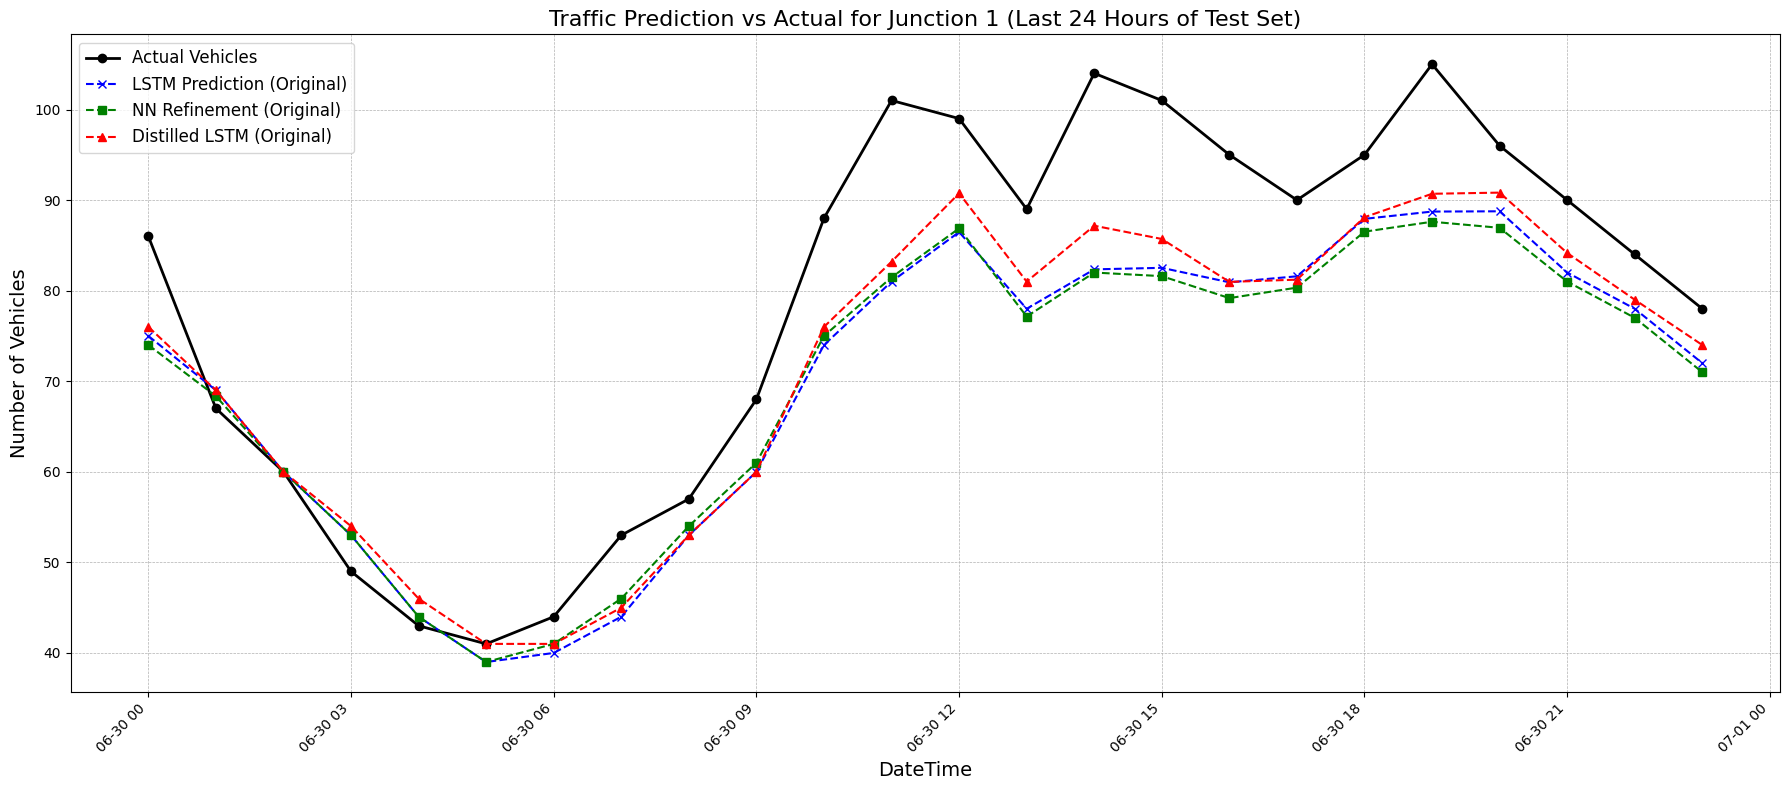

Plot generated for the last 24 hours with original scale predictions and actuals.


In [161]:
import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Plotting Predictions (Last 24 Hours of Test Set) ---")

eval_24h_horizon = 24 # Define the horizon for plotting

if 'results_df' in locals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    if 'DateTime' in results_df.columns:
        try:
            results_df['DateTime'] = pd.to_datetime(results_df['DateTime'])
        except Exception as e:
            print(f"Could not convert DateTime column to datetime objects: {e}")

    plot_df_segment = results_df.tail(eval_24h_horizon)
    if len(plot_df_segment) < eval_24h_horizon :
        print(f"Warning: Plotting fewer than {eval_24h_horizon} points as results_df has only {len(plot_df_segment)} points.")


    actuals_col = 'Actual_Vehicles'
    lstm_original_col = 'LSTM_Pred_Original'
    nn_original_col = 'NN_Refine_Pred_Original'
    distilled_original_col = 'Distilled_LSTM_Pred_Original'

    original_preds_available = all(col in plot_df_segment.columns for col in [lstm_original_col, nn_original_col, distilled_original_col])
    actuals_available = actuals_col in plot_df_segment.columns

    if 'DateTime' not in plot_df_segment.columns or plot_df_segment.empty:
        print("Error: 'DateTime' column missing or segment is empty. Cannot plot.")
    elif original_preds_available and actuals_available:
        plt.figure(figsize=(18, 8))
        plt.plot(plot_df_segment['DateTime'], plot_df_segment[actuals_col], label='Actual Vehicles', marker='o', linestyle='-', color='black', linewidth=2)
        plt.plot(plot_df_segment['DateTime'], plot_df_segment[lstm_original_col], label='LSTM Prediction (Original)', marker='x', linestyle='--', color='blue')
        plt.plot(plot_df_segment['DateTime'], plot_df_segment[nn_original_col], label='NN Refinement (Original)', marker='s', linestyle='--', color='green')
        plt.plot(plot_df_segment['DateTime'], plot_df_segment[distilled_original_col], label='Distilled LSTM (Original)', marker='^', linestyle='--', color='red')
        
        plt.title(f'Traffic Prediction vs Actual for Junction 1 (Last {len(plot_df_segment)} Hours of Test Set)', fontsize=16)
        plt.xlabel('DateTime', fontsize=14)
        plt.ylabel('Number of Vehicles', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        print(f"Plot generated for the last {len(plot_df_segment)} hours with original scale predictions and actuals.")
    # Add other plotting conditions (e.g., scaled data) if needed, adapting them to use plot_df_segment
    else:
        print(f"Could not generate plot: 'plot_df_segment' (last {eval_24h_horizon}h) is missing necessary columns.")
else:
    print("Results DataFrame ('results_df') not found or empty. Cannot plot.")

In [162]:
# --- Calculate Evaluation Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

print("\n--- Calculating Evaluation Metrics ---")

# This prediction_horizon is the length of the full test set (e.g., 20% of data)
# It's implicitly defined by the length of results_df if it came from prediction_horizon_test_set
# For clarity, we can try to get it from `prediction_horizon_test_set` if it exists
# or default to the length of results_df.
# However, the `calculate_and_print_segment_metrics` function uses len(df_segment).

eval_24h_horizon = 24 # Specific horizon for "last 24 hours" evaluation

def calculate_and_print_segment_metrics(df_segment, actual_col_name, model_pred_cols_map, segment_label, scale_label="Original Scale"):
    print(f"\n-- Metrics for {segment_label} ({scale_label}, {len(df_segment)} points) --")
    if df_segment.empty:
        print("   Segment is empty. Skipping metrics.")
        return False # Indicates no metrics were calculated for this segment call
    if actual_col_name not in df_segment.columns:
        print(f"   Actuals column '{actual_col_name}' not found in segment. Skipping metrics.")
        return False
    
    actuals_segment = df_segment[actual_col_name]
    segment_metrics_calculated_at_least_once = False

    for model_name, pred_col_name in model_pred_cols_map.items():
        if pred_col_name not in df_segment.columns:
            print(f"   Prediction column '{pred_col_name}' for {model_name} not found. Skipping for this model.")
            continue
        
        predictions_segment = df_segment[pred_col_name]
        
        # Ensure no NaNs in actuals or predictions for this pair before metric calculation
        valid_indices = ~actuals_segment.isnull() & ~predictions_segment.isnull()
        
        if not valid_indices.any():
            print(f"   No valid (non-NaN) overlapping actuals/predictions for {model_name} in this segment. Skipping.")
            continue
            
        actuals_valid = actuals_segment[valid_indices]
        predictions_valid = predictions_segment[valid_indices]
        
        if len(actuals_valid) == 0: # Should be caught by .any() but as a safeguard
            print(f"   Zero valid data points after NaN removal for {model_name} in this segment. Skipping.")
            continue

        try:
            mae = mean_absolute_error(actuals_valid, predictions_valid)
            rmse = np.sqrt(mean_squared_error(actuals_valid, predictions_valid))
            r2 = r2_score(actuals_valid, predictions_valid)
            print(f"  {model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f} ({len(actuals_valid)} points)")
            segment_metrics_calculated_at_least_once = True
        except Exception as e:
            print(f"   Error calculating metrics for {model_name}: {e}. Skipping.")
            continue
            
    if not segment_metrics_calculated_at_least_once:
        print(f"   No metrics could be calculated for any model in the '{segment_label} ({scale_label})' segment.")
        
    return segment_metrics_calculated_at_least_once

overall_metrics_calculated = False # Tracks if any metrics were calculated across all segments/scales

if 'results_df' in locals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    actuals_col = 'Actual_Vehicles' # Assuming this is the name of your actual values column
    
    print("\nAttempting metrics calculation on ORIGINAL scale...")
    original_model_preds_map = {
        "Base LSTM": 'LSTM_Pred_Original',
        "NN Refinement": 'NN_Refine_Pred_Original',
        "Distilled LSTM": 'Distilled_LSTM_Pred_Original'
    }
    # Check if all necessary original scale columns are present
    required_original_cols = [actuals_col] + list(original_model_preds_map.values())
    all_original_cols_present = all(col in results_df.columns for col in required_original_cols)

    if all_original_cols_present:
        # Metrics for the Full Test Set (e.g., last 20% of Junction 1)
        calc_full_orig = calculate_and_print_segment_metrics(
            results_df, actuals_col, original_model_preds_map,
            "Full Test Set (e.g., Last 20%)", "Original Scale"
        )

        # Metrics for the Last 24 Hours of the Test Set
        last_n_hours_df_orig = results_df.tail(eval_24h_horizon)
        
        # Informative message if the segment is shorter than desired
        if len(last_n_hours_df_orig) < eval_24h_horizon and len(last_n_hours_df_orig) > 0:
            print(f"   -> Note: Evaluating on the last {len(last_n_hours_df_orig)} available points as test set is shorter than {eval_24h_horizon} hours.")
        elif len(last_n_hours_df_orig) == 0 and len(results_df) > 0 : # Test set exists but is too short for tail(eval_24h_horizon)
             print(f"   -> Note: Test set has {len(results_df)} points, but cannot take last {eval_24h_horizon} as it would result in 0 points. Skipping last {eval_24h_horizon}h specific metrics if test set is too short.")


        if not last_n_hours_df_orig.empty:
            calc_last_n_orig = calculate_and_print_segment_metrics(
                last_n_hours_df_orig, actuals_col, original_model_preds_map,
                f"Last {len(last_n_hours_df_orig)} Hours of Test Set", "Original Scale" # Use actual length of segment
            )
        else:
            calc_last_n_orig = False # No calculation if segment is empty

        if calc_full_orig or calc_last_n_orig:
            overall_metrics_calculated = True
    else:
        print("-> Cannot calculate metrics on ORIGINAL scale: One or more required columns missing.")
        missing_cols_details = [col for col in required_original_cols if col not in results_df.columns]
        print(f"   Missing original scale columns: {missing_cols_details}")

    # --- Scaled Metrics (Fallback if original scale metrics were not calculated or if desired) ---
    # Decide if you always want to show scaled, or only if original failed.
    # For this example, let's try scaled if original didn't run or if specifically desired.
    # We'll use 'overall_metrics_calculated' to decide if we *need* to run scaled as a fallback.
    
    # Condition to attempt scaled metrics:
    # 1. Original metrics were not calculated OR
    # 2. You explicitly want to see scaled metrics regardless (remove `not overall_metrics_calculated`)
    attempt_scaled_metrics = not overall_metrics_calculated 
    # To always show scaled metrics if possible, change to:
    # attempt_scaled_metrics = True

    if attempt_scaled_metrics:
        print("\nAttempting metrics calculation on SCALED data...")
        scaled_model_preds_map = {
            "Base LSTM": 'LSTM_Pred_Scaled',
            "NN Refinement": 'NN_Refine_Pred_Scaled', # Assuming this is the name for scaled NN preds
            "Distilled LSTM": 'Distilled_LSTM_Pred_Scaled'
        }
        # For scaled metrics, we need to scale the 'Actual_Vehicles' column temporarily
        # Ensure 'target_scaler' and 'TARGET_COL' (original name for target scaler fitting) are available
        required_cols_for_scaled_fallback = [actuals_col] + list(scaled_model_preds_map.values())
        all_cols_present_for_scaled_fallback = all(col in results_df.columns for col in required_cols_for_scaled_fallback)
        
        # Check if scalers were fitted and necessary variables exist
        scalers_ready_for_fallback = ('scalers_fitted' in locals() and scalers_fitted and
                                      'target_scaler' in locals() and 'TARGET_COL' in locals())

        if all_cols_present_for_scaled_fallback and scalers_ready_for_fallback:
            try:
                temp_scaled_results_df = results_df.copy()
                
                # Prepare actuals for scaling: rename to the name target_scaler expects (TARGET_COL)
                actuals_for_scaling_df = temp_scaled_results_df[[actuals_col]].rename(columns={actuals_col: TARGET_COL})
                
                if actuals_for_scaling_df[TARGET_COL].isnull().any():
                    print(f"Warning: NaNs found in '{actuals_col}' before attempting to scale them for metrics. This might lead to errors or fewer data points.")
                
                # Transform actuals using the fitted target_scaler
                temp_scaled_results_df['Actuals_Scaled_For_Metrics'] = target_scaler.transform(actuals_for_scaling_df)
                
                # Metrics for the Full Test Set (Scaled)
                calc_full_scaled = calculate_and_print_segment_metrics(
                    temp_scaled_results_df, 'Actuals_Scaled_For_Metrics', scaled_model_preds_map,
                    "Full Test Set (e.g., Last 20%)", "Scaled (Quantile Transformed)"
                )

                # Metrics for the Last N Hours of the Test Set (Scaled)
                last_n_hours_df_scaled = temp_scaled_results_df.tail(eval_24h_horizon)
                if len(last_n_hours_df_scaled) < eval_24h_horizon and len(last_n_hours_df_scaled) > 0:
                     print(f"   -> Note: Evaluating on the last {len(last_n_hours_df_scaled)} available points (scaled) as test set is shorter than {eval_24h_horizon} hours.")
                elif len(last_n_hours_df_scaled) == 0 and len(temp_scaled_results_df) > 0:
                     print(f"   -> Note: Scaled test set has {len(temp_scaled_results_df)} points, but cannot take last {eval_24h_horizon} as it would result in 0 points. Skipping last {eval_24h_horizon}h specific scaled metrics if test set is too short.")


                if not last_n_hours_df_scaled.empty:
                    calc_last_n_scaled = calculate_and_print_segment_metrics(
                        last_n_hours_df_scaled, 'Actuals_Scaled_For_Metrics', scaled_model_preds_map,
                        f"Last {len(last_n_hours_df_scaled)} Hours of Test Set", "Scaled (Quantile Transformed)"
                    )
                else:
                    calc_last_n_scaled = False

                if calc_full_scaled or calc_last_n_scaled:
                    overall_metrics_calculated = True # Update if scaled metrics were calculated
                    print("   (Note: Scaled metrics are on the transformed scale, not original vehicle counts)")
            except Exception as e:
                print(f"-> Error calculating metrics on SCALED data: {e}")
        else:
            missing_info = []
            if not all_cols_present_for_scaled_fallback:
                missing_cols_details_scaled = [col for col in required_cols_for_scaled_fallback if col not in results_df.columns]
                missing_info.append(f"actuals ('{actuals_col}') or one or more scaled prediction columns (missing: {missing_cols_details_scaled}) in results_df")
            if not scalers_ready_for_fallback:
                missing_info.append("fitted scalers (scalers_fitted=False, or target_scaler/TARGET_COL missing from environment)")
            print(f"-> Cannot calculate metrics on SCALED data: Missing required components: {', '.join(missing_info)}.")

else:
    print("Cannot calculate metrics: 'results_df' DataFrame not found, is not a DataFrame, or is empty.")

if not overall_metrics_calculated:
     print("\nNo metrics could be calculated for any segment or scale. Please check previous cell outputs for errors and warnings regarding data availability, column names, and scaler status.")


--- Calculating Evaluation Metrics ---

Attempting metrics calculation on ORIGINAL scale...

-- Metrics for Full Test Set (e.g., Last 20%) (Original Scale, 2918 points) --
  Base LSTM: MAE=6.3648, RMSE=8.6493, R2=0.8659 (2918 points)
  NN Refinement: MAE=7.0187, RMSE=9.1510, R2=0.8499 (2918 points)
  Distilled LSTM: MAE=6.2425, RMSE=8.3574, R2=0.8748 (2918 points)

-- Metrics for Last 24 Hours of Test Set (Original Scale, 24 points) --
  Base LSTM: MAE=8.9887, RMSE=10.7611, R2=0.7381 (24 points)
  NN Refinement: MAE=9.2369, RMSE=11.1064, R2=0.7210 (24 points)
  Distilled LSTM: MAE=7.7166, RMSE=9.1948, R2=0.8088 (24 points)
